# Fully discretized, scale factor parameterization

In [1]:
import par
#import bg_test as bg
import numops
from copy import deepcopy as cp
from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numba
plt.rcParams.update(par.plot_params)

In [2]:
# set the A and k arrays.
A = np.linspace(par.a0, par.a_rec, par.N_T_SOLVE)
k_solve= np.geomspace(par.k_low, par.k_high, par.N_K_SOLVE)

In [3]:
"""3 fluid"""
def DY_3fld(i, Y, A, H):
    dY = np.zeros((7, par.N_K_SOLVE))
    Phi = Y[0, :]
    deltaG = Y[1, :]
    vG = Y[2, :]
    deltaC = Y[3, :]
    vC = Y[4, :]
    deltaN = Y[5, :]
    vN = Y[6, :]

    # compute background quantities for the current
    # time step.
    Hi = H[i]
    H0 = par.H0
    ai = A[i]
    ybi = 1.68*ai*par.OmegaB0/par.OmegaR0
  
    OmegaBi = par.OmegaB0 * ai**-3.
    OmegaCi = par.OmegaC0 * ai**-3.
    OmegaGi = par.OmegaG0 * ai**-4.
    OmegaNi = par.OmegaN0 * ai**-4
    

    # compute the derivatives of the perturbations.
    DPhi = -Hi*Phi + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(OmegaGi*vG + OmegaNi*vN) + OmegaCi*vC + OmegaBi*vG)

    DdeltaG = -4./3.*k_solve*vG + 4*DPhi
    DvG = (-Hi * ybi*vG + k_solve*deltaG/3)/(
        4./3. + ybi) + k_solve*Phi

    DdeltaC = -k_solve*vC + 3*DPhi
    DvC = -Hi*vC + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4 + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4. + k_solve*Phi

    dY[0, :] = DPhi
    dY[1, :] = DdeltaG
    dY[2, :] = DvG
    dY[3, :] = DdeltaC
    dY[4, :] = DvC
    dY[5, :] = DdeltaN
    dY[6, :] = DvN

    return dY

@numba.njit
def DY_2fld(i, Y, A, H, wD, DwD, cs2D):
    dY = np.zeros((5, par.N_K_SOLVE))
    Phi = Y[0, :]
    deltaG = Y[1, :]
    vG = Y[2, :]
    deltaD = Y[3, :]
    vD = Y[4, :]

    # get background quantities for the current
    # time step.
    Hi = H[i]
    H0 = par.H0
    ai = A[i]
    ybi = 1.68*ai*par.OmegaB0/par.OmegaR0
    wDi = wD[i]
    DwDi = DwD[i]
    cs2Di = cs2D[:,i]
    OmegaBi = par.OmegaB0 * ai**-3.
    OmegaCi = par.OmegaC0 * ai**-3.
    OmegaGi = par.OmegaG0 * ai**-4.
    OmegaNi = par.OmegaN0 * ai**-4
    

    OmegaDi = OmegaNi + OmegaCi

    # compute the derivatives of the perturbations.
    DPhi = -Hi*Phi + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(OmegaGi*vG) + OmegaBi*vG +(1+wDi)*OmegaDi*vD)

    DdeltaG = -4./3.*k_solve*vG + 4*DPhi
    DvG = (-Hi * ybi*vG + k_solve*deltaG/3)/(
        4./3. + ybi) + k_solve*Phi

    DdeltaD = -(1+wDi)*(k_solve*vD-3*DPhi) - 3*Hi*(cs2Di-wDi)*deltaD
    DvD = -Hi*(1-3*wDi)*vD - vD*DwDi/(1+wDi) + k_solve*deltaD*cs2Di/(1+wDi) + k_solve*Phi

    dY[0, :] = DPhi
    dY[1, :] = DdeltaG
    dY[2, :] = DvG
    dY[3, :] = DdeltaD
    dY[4, :] = DvD

    return dY


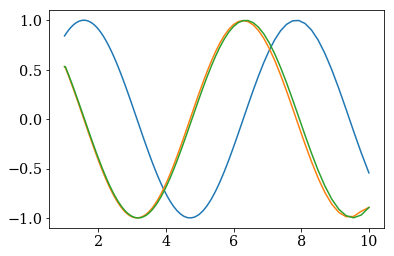

In [4]:
x = np.geomspace(1,10,100)
y = np.sin(x)
plt.plot(x,y)
plt.plot(x,np.gradient(y,x))
plt.plot(x,numops.deriv(x,y))

In [5]:
def solve_3fld(A):
    N = len(A)
    H =  A * par.H0 * np.sqrt(par.OmegaM0*A**-3 + par.OmegaR0*A**-4 +  par.OmegaL0 ) 
    TAU =  par.tau0 + numops.trapz(A, 1/(A * H))
    
    # set initial conditions
    y0 = par.a0/par.a_eq
    Phi0 = np.ones(par.N_K_SOLVE)
    deltaG0 = -2*Phi0*(1 + 3*y0/16)
    vG0 = -k_solve/(H[0]) * (deltaG0/4 + (2*k_solve**2 * (1 + y0)*Phi0) /
                              (9*(H[0])**2 * (4./3. + y0)))
    deltaC0 = .75 * deltaG0
    vC0 = vG0
    deltaN0 = deltaG0
    vN0 = vG0

    Y = np.zeros((N//2, 7, par.N_K_SOLVE))
    Y[0, :, :] = np.array([Phi0, deltaG0, vG0, deltaC0, vC0, deltaN0, vN0])
    # RK4 implementation
    for i in range(N//2-1):
        ss = TAU[2*i+2] - TAU[2*i]
        k1 = ss*DY_3fld(2*i, Y[i, :, :], A, H)
        k2 = ss*DY_3fld(2*i+1, Y[i, :, :]+k1/2, A, H)
        k3 = ss*DY_3fld(2*i+1, Y[i, :, :]+k2/2, A, H)
        k4 = ss*DY_3fld(2*i+2, Y[i, :, :]+k3, A, H)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

@numba.njit
def solve_2fld(A, wD, cs2D, deltaD0, vD0):
     
    N = len(A)
    H =  A * par.H0 * np.sqrt(par.OmegaM0*A**-3 + par.OmegaR0*A**-4 +  par.OmegaL0 ) 
    TAU =  par.tau0 + numops.trapz(A, 1/(A * H))
    DwD = numops.deriv(TAU, wD)
    
    # set initial conditions
    y0 = par.a0/par.a_eq
    Phi0 = np.ones(par.N_K_SOLVE)
    deltaG0 = -2*Phi0*(1 + 3*y0/16)
    vG0 = -k_solve/(H[0]) * (deltaG0/4 + (2*k_solve**2 * (1 + y0)*Phi0) /
                              (9*(H[0])**2 * (4./3. + y0)))
    deltaC0 = .75 * deltaG0
    vC0 = vG0
    deltaN0 = deltaG0
    vN0 = vG0
    
    Y = np.zeros((N//2, 5, par.N_K_SOLVE))
    Y[0,0,:] = Phi0
    Y[0,1,:] = deltaG0
    Y[0,2,:] = vG0
    Y[0,3,:] = deltaD0
    Y[0,4,:] = vD0
    
    #Y[0, :, :] = np.array([Phi0, deltaG0, vG0, deltaD0, vD0])
    # RK4 implementation
    for i in range(N//2-1):
        ss = TAU[2*i+2] - TAU[2*i]
        k1 = ss*DY_2fld(2*i, Y[i, :, :], A, H, wD, DwD, cs2D)
        k2 = ss*DY_2fld(2*i+1, Y[i, :, :]+k1/2, A, H, wD, DwD, cs2D)
        k3 = ss*DY_2fld(2*i+1, Y[i, :, :]+k2/2, A, H, wD, DwD, cs2D)
        k4 = ss*DY_2fld(2*i+2, Y[i, :, :]+k3, A, H, wD, DwD, cs2D)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

   


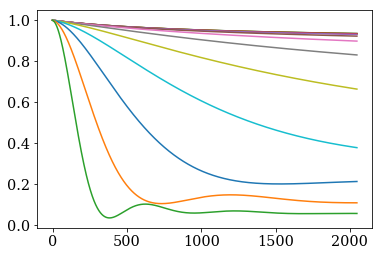

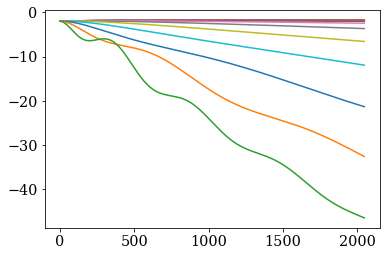

35.8 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
Y = solve_3fld(A)
plt.plot(Y[:,0,::20])
plt.show()


Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T


OmegaB = par.OmegaB0 * A[::2]**-3
OmegaC = par.OmegaC0 * A[::2]**-3
OmegaN = par.OmegaN0 * A[::2]**-4
OmegaG = par.OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN*1/3)/(deltaD*OmegaD)

plt.plot(deltaD.T[:,::20])
plt.show()

%timeit Y2 = solve_2fld(A[::2], wD, cs2D, deltaD[:,0], vD[:,0])
#plt.plot(Y2[:,3,::20])
#plt.show()

In [ ]:
#Y = solve_3fld_fix(par.MLparams)
TAU_out = TAU[::2]
Y = solve(par.MLparams)
Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC = np.array([np.interp(TAU, TAU_out, Y[:, 3, j].T) for j in range(256)])
vC = np.array([np.interp(TAU, TAU_out, Y[:, 4, j].T) for j in range(256)])
deltaN = np.array([np.interp(TAU, TAU_out, Y[:, 5, j].T) for j in range(256)])
vN = np.array([np.interp(TAU, TAU_out, Y[:, 6, j].T) for j in range(256)])



OmegaB = par.OmegaB0 * A**-3
OmegaC = par.OmegaC0 * A**-3
OmegaN = par.OmegaN0 * A**-4
OmegaG = par.OmegaG0 * A**-4
OmegaD = OmegaN + OmegaC

wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN*1/3)/(deltaD*OmegaD)

par_2f = cp(par.MLparams)
par_2f['wD'] = OmegaN/(3*OmegaD)
par_2f['cs2D'] = cs2D
par_2f['OmegaD_tau0'] = par.OmegaN0 + par.OmegaG0
par_2f['deltaD0'] = deltaD[:,0]
par_2f['vD0'] = vD[:,0]
#print(np.shape(par_2f['deltaD0']))
par_2f['OmegaC0'] = 0
par_2f['OmegaN0'] = 0

Y2f = solve(par_2f)

In [ ]:
"""Extract GDM functions

OmegaB = par.OmegaB0 * A[::2]**-3
OmegaC = par.OmegaC0 * A[::2]**-3
OmegaN = par.OmegaN0 * A[::2]**-4
OmegaG = par.OmegaG0 * A[::2]**-4

OmegaD = OmegaN + OmegaC

wd = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wd)*OmegaD)
cs2d = (deltaN*OmegaN*1/3)/(deltaD*OmegaD)
"""

In [ ]:
# plot some outputs for sanity check
plt.plot(TAU_out, deltaD.T[:, 0::25])
plt.show()
plt.plot(TAU_out, Phi.T[:, 0::25])
plt.show()